<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/06-graph-neural-networks-1-gnn-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    %pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-geometric

# Graph Neural Networks 1: GNN Model

In [2]:
from typing import Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

## Cora Dataset

> From The [Papers With Code page of the Cora Dataset](https://paperswithcode.com/dataset/cora): "The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words."

> From [Kipf & Welling (ICLR 2017)](https://arxiv.org/abs/1609.02907): "[...] evaluate prediction accuracy on a test set of 1,000 labeled examples. [...] validation set of 500 labeled examples for hyperparameter optimization (dropout rate for all layers, L2 regularization factor for the first GCN layer and number of hidden units). We do not use the validation set labels for training."

In [3]:
dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
# For num. edges see:
# - https://github.com/pyg-team/pytorch_geometric/issues/343
# - https://github.com/pyg-team/pytorch_geometric/issues/852
num_edges = dataset.data.num_edges // 2
train_len = dataset[0].train_mask.sum()
val_len = dataset[0].val_mask.sum()
test_len = dataset[0].test_mask.sum()
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Dataset len.: {dataset.len()}")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1


> From [Kipf & Welling (ICLR 2017)](https://arxiv.org/abs/1609.02907): "We initialize weights using the initialization described in Glorot & Bengio (2010) and accordingly (row-)normalize input feature vectors."

In [4]:
dataset = Planetoid("/tmp/Cora", name="Cora")
print(f"Sum of row values without normalization: {dataset[0].x.sum(dim=-1)}")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[0].x.sum(dim=-1)}")

Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


## Graph Convolutional Networks

> From [Kipf & Welling (ICLR 2017)](https://arxiv.org/abs/1609.02907): "We used the following sets of hyperparameters for Citeseer, Cora and Pubmed: 0.5 (dropout rate), $5\cdot10^{-4}$ (L2 regularization) and 16 (number of hidden units);"

In [5]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        num_classes: int,
        hidden_dim: int = 16,
        dropout_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x: Tensor, edge_index: Tensor) -> torch.Tensor:
        x = self.dropout1(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.conv2(x, edge_index)
        return x

In [6]:
print("Graph Convolutional Network (GCN):")
GCN(dataset.num_node_features, dataset.num_classes)

Graph Convolutional Network (GCN):


GCN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 7)
)

## Training and Evaluation

In [7]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    return loss.item(), acc

> From [Kipf & Welling (ICLR 2017)](https://arxiv.org/abs/1609.02907): "We train all models for a maximum of 200 epochs (training iterations) using Adam (Kingma & Ba, 2015) with a learning rate of 0.01 and early stopping with a window size of 10, i.e. we stop training if the validation loss does not decrease for 10 consecutive epochs."

In [8]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    seed: Optional[int] = 42,
    verbose: bool = True,
) -> HistoryDict:
    torch.manual_seed(seed)
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

In [9]:
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()


Epoch: 0
----------
Train loss: 1.9460 | Train acc: 0.1500
  Val loss: 1.9480 |   Val acc: 0.0820

Epoch: 20
----------
Train loss: 1.7267 | Train acc: 0.6500
  Val loss: 1.8245 |   Val acc: 0.4860

Epoch: 40
----------
Train loss: 1.4002 | Train acc: 0.7857
  Val loss: 1.6003 |   Val acc: 0.6980

Epoch: 60
----------
Train loss: 0.9969 | Train acc: 0.8714
  Val loss: 1.3578 |   Val acc: 0.7540

Epoch: 80
----------
Train loss: 0.7222 | Train acc: 0.9286
  Val loss: 1.1672 |   Val acc: 0.7720

Epoch: 100
----------
Train loss: 0.6089 | Train acc: 0.9214
  Val loss: 1.0402 |   Val acc: 0.7800

Epoch: 120
----------
Train loss: 0.5035 | Train acc: 0.9071
  Val loss: 0.9487 |   Val acc: 0.7860

Early stopping...

Epoch: 127
----------
Train loss: 0.5273 | Train acc: 0.9500
  Val loss: 0.9461 |   Val acc: 0.7760
 Test loss: 0.9202 |  Test acc: 0.8080


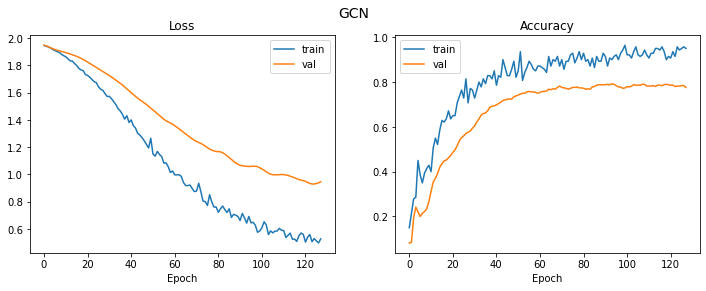

In [10]:
SEED 
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

plt.figure(figsize=(12, 4))
plot_history(history, "GCN")